# 주제: Object Detection Model 구현하기

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 import 가능합니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.

## 데이터 소개
    - 이번 주제는 MS-COCO 2017 dataset을 사용합니다.
    - 이번에 사용하는 MS-COCO dataset은 tfrecord 형태로 저장되어 있으며, 내부에 다양한 정보를 담고 있습니다. 
      그 중에 이번 주제와 관련된 내용들은 다음과 같습니다.

    1. image
      - 각 image의 pixel 값(3차원 tensor)
      - image/filename: image file의 이름
      - image/id: image file의 id(file명에서 확장자 제외한 부분)      
      
    2. objects
      - objects/area: 각 bounding box들의 면적 
      - objects/id: 각 bounding box의 id
      - objects/bbox: 각 bounding box의 좌표(ymax, xmax, ymin, xmin)
      - objects/label: 각 bounding box에 대한 classification 정답

- 원본 데이터 출처: https://cocodataset.org/#home
- data format 참고: https://cocodataset.org/#format-data

## 문제 소개
    - 이번 실습에서는 1-stage object detection model인 RetinaNet을 직접 만들고 학습시켜보도록 하겠습니다.

## RetinaNet
    - Paper: https://arxiv.org/abs/1708.02002
    - RetinaNet에 대한 강의가 따로 준비되어 있으니 강의를 시청하시고 문제를 풀어보시기 바랍니다.

## 최종 목표    
    - Object Detection Model에 대한 이해
    - Object Detection Model 구현

- 출제자: 이진원 강사

## Step 1. Data 다운로드 및 확인

In [1]:
## library를 import 합니다
## 추가로 필요한 library가 있으면 추가로 import 해도 좋습니다
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import gdown

In [2]:
## Hyper parameter 및 기타 설정
num_classes = 80
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

## ckpt 저장할 directory
model_dir = "retinanet"

### 문제 1. Data 불러오기

    - data는 아래 url(google drive)에 저장되어 있습니다.(zip 파일)
    - gdown library를 이용하여 data를 다운받고, zip파일 압축을 풀어줍니다.
    - 압축 파일은 data라는 이름의 directory에 풀도록 합니다.

In [3]:
url = "https://drive.google.com/uc?id=1vIHxg4fLsK7Vn1NnZ_toK4akqpT5ZoKM"

In [4]:
## data download 받고(gdown.download 사용) 압축 풀기
gdown.download(url, 'data.zip', quiet=False)

with zipfile.ZipFile('data.zip','r') as f:
    f.extractall('./data')

Downloading...
From: https://drive.google.com/uc?id=1vIHxg4fLsK7Vn1NnZ_toK4akqpT5ZoKM
To: /content/data.zip
100%|██████████| 278M/278M [00:01<00:00, 156MB/s]


    - 위에서 다운받은 파일은 실제 MS-COCO data의 일부만을 포함하고 있습니다.
    - 아래의 cell을 실행하면 이 data를 이용하여 dataset을 만들 수 있습니다. 
    - MS-COCO data 전체가 필요한 경우 아래 data_dir='data' 부분을 data_dir=None 으로 변경하면 됩니다.


In [5]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir='data'
)

    - dataset_info를 통해서 data에 관한 어떤 정보들이 있는지 확인해봅시다.

In [6]:
dataset_info

tfds.core.DatasetInfo(
    name='coco',
    version=1.1.0,
    description='COCO is a large-scale object detection, segmentation, and
captioning dataset. This version contains images, bounding boxes "
and labels for the 2017 version.
Note:
 * Some images from the train and validation sets don't have annotations.
 * Coco 2014 and 2017 uses the same images, but different train/val/test splits
 * The test split don't have any annotations (only images).
 * Coco defines 91 classes but the data only uses 80 classes.
 * Panotptic annotations defines defines 200 classes but only uses 133.',
    homepage='http://cocodataset.org/#home',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'image/id': tf.int64,
        'objects': Sequence({
            'area': tf.int64,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'id': tf.int64,
            'is_crowd': tf.bool,
 

    - tfds.show_examples를 활용하여 data에 포함된 image를 출력해봅시다.

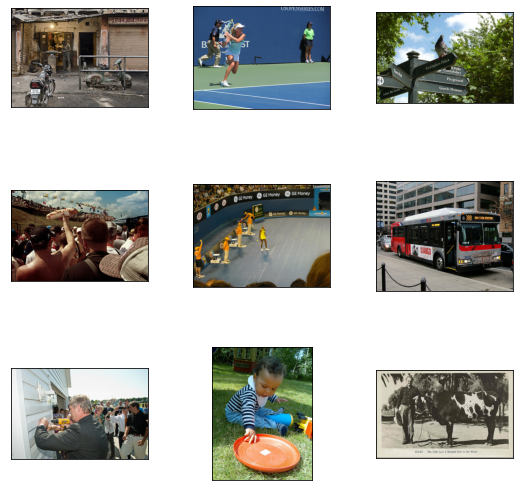

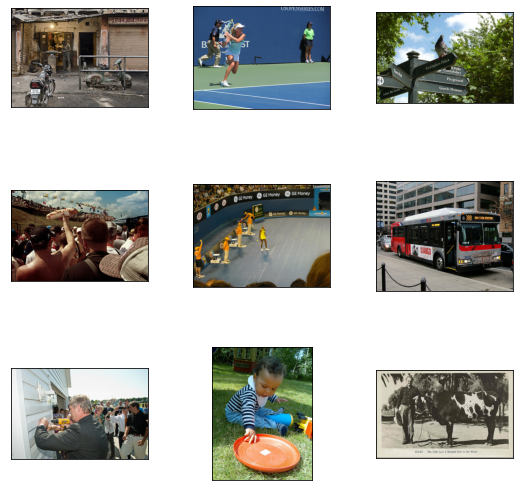

In [7]:
tfds.show_examples(train_dataset, dataset_info)

### 문제 2. Dataset 내부 item 확인
    - train_dataset에서 data를 하나 꺼내서 내부 item을 print 문으로 확인해봅시다.

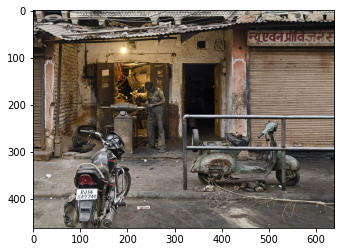

{'image': <tf.Tensor: shape=(462, 640, 3), dtype=uint8, numpy=
array([[[  5,  11,  11],
        [ 15,  15,  13],
        [ 17,  20,  25],
        ...,
        [136, 129, 119],
        [116, 118, 107],
        [105, 105,  97]],

       [[  6,  10,  11],
        [ 19,  19,  17],
        [ 15,  18,  23],
        ...,
        [220, 221, 207],
        [206, 202, 190],
        [169, 167, 155]],

       [[ 18,  19,  21],
        [  9,   8,   6],
        [ 20,  24,  27],
        ...,
        [225, 221, 210],
        [227, 218, 209],
        [215, 208, 200]],

       ...,

       [[181, 174, 164],
        [175, 168, 158],
        [154, 145, 136],
        ...,
        [ 75,  74,  70],
        [ 76,  74,  75],
        [ 73,  72,  70]],

       [[160, 153, 143],
        [159, 152, 142],
        [166, 158, 147],
        ...,
        [ 83,  82,  77],
        [ 68,  66,  69],
        [ 87,  86,  82]],

       [[144, 138, 126],
        [155, 149, 137],
        [160, 152, 141],
        ...,
        [ 8

In [8]:
for data in train_dataset.take(1):
    plt.imshow(data['image'])
    plt.show()
    print(data)

### 문제 3. Data 직접 확인하기
    - 문제 2와 같이 dataset에서 1개의 data를 가져온 후,
      image와 bounding box를 화면에 함께 출력해봅시다. 
    - data에 저장된 bounding box의 좌표는 box의 양쪽 모서리의 좌표이며, 
      (ymin, xmin, ymax, xmax)의 순서로 되어 있습니다.    

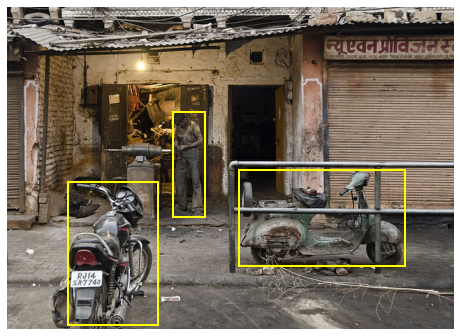

In [9]:
for data in train_dataset.take(1):
  image = np.array(data['image'], dtype=np.uint8)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(image)
  ax = plt.gca()
  boxes = data['objects']['bbox']

  image_h, image_w, image_d = image.shape
  boxes = tf.stack(
      [
       boxes[:,0] * image_h,
       boxes[:,1] * image_w,
       boxes[:,2] * image_h,
       boxes[:,3] * image_w
      ], axis=-1 )
  for box in boxes:
      ymin, xmin = box[:2]
      h, w = box[2:] - box[:2]
      patch = plt.Rectangle(
          [xmin, ymin], w, h, fill=False, edgecolor=[1,1,0], linewidth=2
      )
      ax.add_patch(patch)
  plt.show()

## Step 2. Data Augmentation
이번 Step에서는 data augmentation을 구현해보도록 하겠습니다.

    - 행렬과 같은 tensor의 경우 행->열 순서로 되어 있기 때문에 (y좌표, x좌표) 순서로 저장되어 있습니다.
    - (x좌표, y좌표) 순서가 더 직관적으로 이해하기 쉬우므로 저장된 x, y좌표의 순서를 바꿔주는 함수를 만들어봅시다.
    - 함수의 입력은 (N, 4) shape의 bounding box 정보이며, 
      bounding box 좌표 정보는 양쪽 모서리의 x, y 좌표값으로 되어 있다고 가정합니다.

In [10]:
boxes

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[251.24   ,  86.17   , 455.77002, 215.95   ],
       [234.27   , 331.44   , 371.66998, 570.32   ],
       [150.84   , 236.62001, 301.24   , 283.64   ]], dtype=float32)>

In [11]:
boxes[:,1]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 86.17   , 331.44   , 236.62001], dtype=float32)>

In [12]:
np.c_[boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]]

array([[ 86.17   , 251.24   , 215.95   , 455.77002],
       [331.44   , 234.27   , 570.32   , 371.66998],
       [236.62001, 150.84   , 283.64   , 301.24   ]], dtype=float32)

In [13]:
tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 86.17   , 251.24   , 215.95   , 455.77002],
       [331.44   , 234.27   , 570.32   , 371.66998],
       [236.62001, 150.84   , 283.64   , 301.24   ]], dtype=float32)>

In [14]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

### 문제 4. Bounding box format 변경하는 함수 만들기 1
    - bounding box의 위치 정보에 대한 format을 변경하는 함수를 만들어 봅시다.
    - (xmin, ymin, xmax, ymax) 형태의 bounding box format을 (x, y, w, h)로 바꿔서 반환합니다.
    - 이 때 x, y는 bounding box의 center 좌표를 의미합니다.
    - 함수의 입력은 (..., N, 4)와 같이 2차원 이상의 tensor입니다.

In [15]:
boxes[...,:2]

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[251.24   ,  86.17   ],
       [234.27   , 331.44   ],
       [150.84   , 236.62001]], dtype=float32)>

In [16]:
boxes[...,2:] - boxes[...,:2]

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[204.53001 , 129.78    ],
       [137.39998 , 238.88    ],
       [150.4     ,  47.020004]], dtype=float32)>

In [17]:
def convert_to_xywh(boxes):    
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

### 문제 5. Bounding box format 변경하는 함수 만들기 2
    - bounding box의 위치 정보에 대한 format을 변경하는 함수를 만들어 봅시다.
    - (x, y, w, h) 형태의 bounding box format을 (xmin, ymin, xmax, ymax)로 바꿔서 반환합니다.
    - 이 때 x, y는 bounding box의 center 좌표를 의미합니다.
    - 함수의 입력은 (..., N, 4)와 같이 2차원 이상의 tensor입니다.

In [18]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )

### 문제 6. Image resizing 함수 만들기
    - 짧은 변을 min_side와 같게 resize 합니다
    - 만약에 긴 변의 길이가 max_side보다 클 경우에는 긴 변이 max_side와 같아지도록 다시 resize 합니다
    - image size(가로, 세로 모두)가 stride의 배수가 아닐 경우 stride의 배수가 되도록 오른쪽과 아래쪽에 0을 채웁니다(zero padding) 
    - 함수의 입력값은 다음과 같습니다.
      1. image: 3차원 tensor로 이루어진 image(feature map)의 pixel 값(height, width, channel)
      2. min_side: resize에 사용할 짧은 변 길이
      3. max_side: resize에 사용할 긴 변 길이
      4. stride: 1번 입력인 image(feature map)의 1 pixel이 실제 원본 image에서 몇 pixel에 해당되는지
    - 함수의 반환값은 3가지이고 각각 다음과 같습니다.
      1. resize 및 padding된 image(feature map)의 pixel 값
      2. padding 하기 전의 image size
      3. padding 하기 전 image와 원본 image의 확대/축소 비율(resize 후/resize 전)


In [19]:
tf.cast(image.shape[:2], dtype=tf.float32)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([462., 640.], dtype=float32)>

In [20]:
def resize_and_pad_image(image, min_side=800.0, max_side=1333.0, stride=128.0):    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)    
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

### 문제 7. Horizontal flip 함수 만들기
    - 50%의 확률로 image를 좌우반전합니다
    - 이 때 bounding box의 좌표도 좌우반전에 맞게 변경합니다
    - 입력 image는 3차원 tensor로 (height, width, channel)로 구성되어 있습니다.
    - bounding box의 좌표는 (xmin, ymin, xmax, ymax)로 구성되어 있고, 각각의 좌표는 0~1 사이 값으로 normalized 되어 있다고 가정합니다.
    - 함수의 반환값은 image의 pixel 값, bounding box의 좌표로 합니다.

In [21]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1-boxes[:,2], boxes[:,1], 1-boxes[:,0], boxes[:,3]], axis=-1
        )
    return image, boxes

### 문제 8. Augmentation 함수 만들기
    - tf.data(dataset)에 map으로 적용할 수 있도록 함수를 만듭니다.
    - 입력으로 dataset의 item을 받습니다
    - 위에서 작성한 random_flip_horizontal 함수를 먼저 적용하고, 다음으로 resize_and_pad_image 함수를 적용합니다.
    - 0~1 사이 값으로 normailized된 bounding box 좌표를 실제 image size에 맞게 조정합니다.
    - bounding box 좌표를 (xmin, ymin, xmax, ymax) 형태에서 (x, y, w, h) 형태로 변경합니다.
    - 함수의 반환값은 image의 pixel 값, bounding box의 좌표, class id로 합니다.

In [22]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [bbox[:, 0] * image_shape[1],
         bbox[:, 1] * image_shape[0],
         bbox[:, 2] * image_shape[1],
         bbox[:, 3] * image_shape[0]],
         axis=-1
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

## Step 3. Anchor Box 정보 만들기
AnchorBox class를 만들고, 모든 anchor box의 (x, y, w, h) 정보를 생성해봅시다.

      * _compute_dims: 각 level별로 ahcnor box의 (w,h)를 계산하여 반환합니다.
      * _get_anchors: 각 level별로 anchor box의 (x,y,w,h)를 계산하여 반환합니다. 이 때 return shape은 (height*width*9, 4)입니다.
      * get_anchors: _get_anchors의 level별 anchor box정보를 모두 합쳐서 최종 결과를 반환합니다.

    - AnchorBox class를 만들고, get_anchors method를 call하면 모든 anchor box의 (x,y,w,h) 좌표를 반환하도록 합니다.    
    - P3-P7까지의 모든 level의 anchor box의 (x,y,w,h) 좌표가 반환되어야 합니다.
    - 계산의 편의를 위하여 먼저 각 level의 anchor box를 (height, width, 9, 4)의 shape을 갖는 tensor로 만듭니다. 
      여기서 height, width는 각 level의 feature map size를 의미하며, 9는 각 level의 anchor box 갯수이며 4는 (x,y,w,h)를 말합니다.
    - 최종적으로 반환되는 값은 (5*height*width*9, 4)의 형태가 되며 맨 앞의 5는 level의 갯수(P3, P4, P5, P6, P7)을 의미합니다.

Class 내부의 method는 다음과 같습니다

### \_\_init\_\_ method
    - __init__ : anchor box 정보 계산을 위한 기본 값들 setting

### 문제 9. _compute_dims method
    - _compute_dims method를 만들어봅시다.
    - _compute_dims는 모든 level(P3-P7)에 대하여 각 level별로 anchor box의 (w, h)를 계산하여 반환하는 역할을 합니다.
    - anchor_dims_all list에 해당 정보가 저장되며 list의 원소는 각각 (1,1,9,2)의 shape을 갖게 됩니다.

### 문제 10. _get_anchors method
    - _get_anchors method를 만들어봅시다.
    - _get_anchors method는 각 level별로 anchor box의 (x,y,w,h)를 계산하여 반환합니다.
    - 반환값의 shape은 (height*width*9, 4)입니다.

### 문제 11. get_anchors method
    - get_anchors method를 만들어봅시다.
    - get_anchors method는 문제 9의 _get_anchors 를 통해서 level별 anchor box의 정보를 받아 이를 모두 합쳐서 최종 결과를 반환합니다.
    - 반환값의 shape은 (5*height*width*9, 4)입니다.

In [23]:
class AnchorBox:
    def __init__(self):        
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1,1,2]
                    )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all # [5, 1,1,9,2]

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level-3]
        centers = tf.expand_dims(centers, axis=-2) # (70, 100, ?, 2)
        centers = tf.tile(centers,[1, 1, self._num_anchors, 1]) #(70,100,9,2)
        dims = tf.tile(
            self._anchor_dims[level-3], [feature_height, feature_width, 1, 1]) # 70,100,9,2
        anchors = tf.concat([centers, dims], axis=-1) # 70, 100,9, 4
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [            
            self._get_anchors(tf.math.ceil(image_height / 2 ** i),
                              tf.math.ceil(image_width / 2 ** i),
                              i
            ) for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

## Step 4. Label Encoding
anchor box 정보와 정답(groundtruth) box 정보, class id를 이용하여 detection에서 사용할 label을 만들어봅시다.

### 문제 12. IOU 계산 함수 만들기

    - 이 함수는 2개의 bounding box 그룹들(boxes1, boxes2) 간에 iou를 계산합니다
    - 모든 anchor box와 gound truth box 간의 iou를 계산하여,
      anchor box들을 positive, negative, ignore로 구분하기 위해서 사용합니다
    - 각 bounding box의 좌표 정보는 (x,y,w,h) 형태로 입력받습니다.
    - boxes1의 shape은 (N, 4)이고 boxes2의 shape은 (M, 4)라고 할 때, 출력은 (N, M) shape의 tensor가 됩니다.

In [24]:
def compute_iou(boxes1, boxes2): # anchor boxes, groundtruth
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:,None,:2], boxes2_corners[:,:2]) # (1000,1,2), (1,3,2)-> (1000,1,2),(1000,3,2) -> (1000,3,2),(1000,3,2)
    rd = tf.maximum(boxes1_corners[:,None,2:], boxes2_corners[:,2:])
    intersection = tf.maximum(rd-lu, 0) # intersection이 음수일 경우도 처리
    intersection_area = intersection[:,:,0] * intersection[:,:,1] # width * height
    boxes1_area = boxes1[:,2] * boxes1[:,3]
    boxes2_area = boxes2[:,2] * boxes2[:,3]
    union_area = tf.maximum(boxes1_area[:,None] + boxes2_area - intersection_area, 1e-8) #NaN 방지
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

### LabelEncoder Class
이제 LabelEncoder class를 작성해보겠습니다.
이 class에서는 앞에서 생성한 anchor box 정보와 groundtruth box 정보, class id를 이용하여 실제 학습에 사용할 label을 생성해줍니다.
해당 class의 method는 다음과 같습니다.

### \_\_init\_\_ method

    - AnchorBox class instance 생성
    - box normalize를 위한 variance
    


### 문제 13. _match_anchor_boxes method
    - IOU를 기반으로 gt box를 anchor box에 matching하는 역할을 합니다. 
    - M개의 anchor box와 N개의 gt box에 대하여 계산된 MxN의 iou matrix를 이용하여 각 행에서 IOU의 최대값을 찾습니다.
    - 이 때 최대 IOU에 해당되는 index도 저장합니다.(matched_gt_index)
    - 최대 IOU 값이 match_iou 이상이면 positive, ignore_iou 미만이면 negative, 나머지는 ignore로 처리하여
      각 anchor box마다 positive, negative, ignore 여부를 알 수 있는 postive_mask, negative mask, ignore_mask를 생성합니다.
    - 입력값은 anchor box의 (x,y,w,h)정보, gt box의 (x,y,w,h)정보, match_iou, ignore_iou 입니다.
    - 반환값은 matched_gt_index, positive_mask, ignore_mask 입니다. (matched는 one-hot)

### 문제 14. _compute_box_target method
    - 각 anchor box에 대한 transform 값을 계산합니다.
    - transform은 gt box와 같아지기 위해서 anchor box의 x,y,w,h를 얼마나 변형해야 하는가에 대한 값입니다.
    - 입력값으로 각 anchor box와 그에 대한 target 값을 받습니다.
    - 반환값은 각 anchor box의 transform label입니다. 

### 문제 15. _encode_sample method
    - 각 anchor box에 대한 bbox와 class의 target 값을 계산합니다.
    - _match_anchor_boxes method에서 계산한 최대 IOU의 index를 활용하여 해당되는 gt box의 정보를 찾아서 matching 해줍니다.
    - matching돤 gt box의 x,y,w,h와 _compute_box_target method를 이용하여, box regression에 대한 label을 생성합니다.
    - matching된 gt box의 class id와 positive_mask, ignore_mask를 이용하여 class에 대한 label을 생성합니다.
    - 이 때 positive인 경우는 gt의 class id를 사용하고, negative인 경우는 -1로 ignore인 경우는 -2로 labeling합니다.
    - 입력값으로 image shape(batch, height, width, channel), gt box의 (x,y,w,h), gt box의 class id를 받습니다.
    - 최종적으로 box target과 class target을 하나로 concat하여 반환합니다. 


### 문제 16. encode_batch method
    - tf.data(dataset)에 map으로 적용할 수 있도록 합니다.
    - batch 단위로 data를 받아서, 각 image마다 위에서 작성한 method들을 활용하여 label을 생성하고,
      그 label들을 다시 batch 단위로 묶어서 반환합니다.
    - 입력값으로 batch 단위의 image data, gt box의 (x,y,w,h), gt box의 class id를 받습니다.
    - 반환값은 batch 단위의 image data(입력값 그대로)와, 생성한 label입니다.

In [25]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4):        
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
             (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
             tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):       
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
          label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
          labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

## Step 5. Dataset 만들기
앞에서 작성한 함수와 class를 활용하여 model에 data를 공급하기 위한 dataset을 만들어봅시다.


### 문제 17. Train/Validation dataset 만들기
    - 위에서 생성한 train_dataset, validation_dataset과 그동안 작성한 함수와 class들을 활용하여,
      train/validation dataset을 만듭니다.
    - 다음과 같은 순서로 적용합니다.
      1. preprocess_data 함수 적용
      2. dataset shuffle
      3. padded_batch를 이용하여 batch로 묶음
        - 이 때, padding 값은 image, box 좌표, class id에 대하여 각각 0.0, 1e-8, -1로 합니다.
      4. LabelEncoder의 encode_batch 함수 적용
      5. prefetch 적용
    - validation_dataset에는 shuffle만 빼고 동일하게 적용합니다.



In [26]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(batch_size * 8)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)


val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

## Step 6. RetinaNet Model 만들기
Data가 준비되었으므로, RetinaNet model을 만들어보도록 하겠습니다.

### 문제 18. get_backbone 함수 만들기
    - backbone으로 ResNet50을 사용합니다.
    - get_backbone 함수는 ResNet50의 C3, C4, C5에 해당하는 feature map을 output으로 하는 model을 반환합니다.


먼저 ResNet50을 가져와서 C3, C4, C5에 해당하는 layer의 이름을 확인합니다.

In [27]:
backbone = keras.applications.ResNet50(include_top=False, input_shape=[224, 224, 3])

In [28]:
backbone.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

확인된 layer 이름을 활용하여 get_backbone 함수를 작성합니다.

In [29]:
def get_backbone():    
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

### 문제 19. Feature Pyramid Network 만들기
keras custom layer를 활용하여 FPN을 만들어봅시다.

    - input으로 batch 단위의 image를 받고 output으로 P3-P7을 반환합니다.
    - RetinaNet과 FPN 논문의 Feature Pyramid Network 부분을 참고하여 작성합니다.

In [30]:
class FeaturePyramid(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))        
        return p3_output, p4_output, p5_output, p6_output, p7_output

### 문제 20. Class/Box subnet 만들기
classification과 box regression을 위한 subnet(head)를 만들어봅시다.

    - classification과 box regression의 subnet 구조가 동일하므로 공통으로 사용할 수 있는 함수 형태로 작성합니다.
    - 이 함수는 입력값으로 마지막 layer의 convolution filter 수와 bias initializaer를 받습니다.
    - channel이 256인 feature map을 입력으로 classification 혹은 box regression의 결과를 뽑아주는 모델을 반환합니다. 

In [31]:
def build_head(output_filters, bias_init):
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)

    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding='same', kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

### 문제 21. RetinaNet model 만들기
위에서 작성한 layer 및 함수를 이용하여 RetinaNet model을 만들어봅시다.

    - keras subclassing model을 이용하여 작성합니다.
    - 입력으로 image를 받고, 출력으로 모든 anchor box의 regression과 classification 예측값을 모아서 반환합니다.
    - classification subnet에는 RetinaNet 논문에 나온 bias initialzation을 적용합니다.
    - output shape은 (batch size, 전체 anchor box의 갯수, num_classes+4[84]) 입니다.

In [32]:
class RetinaNet(keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid()
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []

        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature),[N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

## Step 7. Model 학습하기
Loss function을 정의하고 RetinaNet model을 학습해봅시다.

### 문제 22. Smooth L1 loss
    - box regression을 위한 smooth l1 loss를 만들어봅시다.
    - tf.losses.Loss class의 subclass로 custom loss를 만듭니다.
    - l1, l2 loss가 변하는 지점의 값은 delta 값으로 __init__ method에서 입력받습니다.

In [33]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5
        )
        
        return tf.reduce_sum(loss, axis=-1)

### 문제 23. Focal loss
    - classification을 위한 focal loss를 만들어봅시다.
    - smooth l1 loss와 마찬가지로 subclassing을 이용하고, 논문의 수식을 참고하여 구현합니다.
    - alpha, gamma 값은 __init__ method에서 설정합니다.

In [34]:
class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1-probs)
        loss = alpha * tf.pow(1.0-pt, self._gamma) * cross_entropy

        return tf.reduce_sum(loss, axis=-1)

### 문제 24. RetinaNet loss
    - smooth l1 loss와 focal loss를 합쳐서 RetinaNet loss를 만들어봅시다.
    - classification loss는 ignore의 경우를 제외합니다.
    - box regression loss는 positive에 대해서만 계산합니다.
    - 각 loss는 positive sample의 갯수로 normalize합니다.
    - 최종 loss는 classification loss와 regression loss를 더해서 계산합니다.


In [35]:
class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._cls_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

        cls_loss = self._cls_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)

        loss = cls_loss + box_loss
        return loss

### 문제 25. Model compile
    - RetinaNet model을 만들고, RetenaNet loss를 이용하여 model을 compile 해봅시다.
    - optimizer는 momentum SGD를 사용하고, momentum 값은 0.9를 사용합니다.
    - learning rate schedule은 위에서 hyperparameter 설정부분에서 만들어 둔 것을 사용합니다.

In [36]:
model = RetinaNet(num_classes)
loss_fn = RetinaNetLoss()
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

### Checkpoint callback
    - 다음과 같이 model의 weight를 저장하기 위한 checkpoint callback을 만듭니다.

In [37]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

### Model 학습하기
    - model.fit으로 model을 학습합니다.
    - MS-COCO 전체 data를 이용하여 학습하는 경우에는 아래 주석 처리된 부분의 주석을 지우고,
      epochs = 1 부분을 삭제,
      train_dataset.take(100), val_dataset.take(50)의 .take 부분을 삭제하면 학습할 수 있습니다.

In [38]:
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // batch_size
# val_steps_per_epoch = \
#     dataset_info.splits["validation"].num_examples // batch_size

# train_steps = 4 * 100000
# epochs = train_steps // train_steps_per_epoch

epochs = 1

model.fit(
    train_dataset.take(10),
    validation_data=val_dataset.take(5),
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

     10/Unknown - 77s 6s/step - loss: 134.3932
Epoch 00001: saving model to retinanet/weights_epoch_1
10/10 [==============================] - 99s 8s/step - loss: 134.3932 - val_loss: 153.4893


## Step 8. 학습된 Model로 결과 확인하기
학습된 model의 weight를 불러와서 validation set에 대하여 detection 결과를 확인해봅시다.

### 학습된 Weights Loading
    - 미리 학습해둔 weights를 아래와 같이 다운받고, model에 load 합니다.

In [39]:
ckpt_url = "https://drive.google.com/uc?id=19snoNsuyeLPxkj9Is1cMmY-JviTydZim"

gdown.download(ckpt_url, 'ckpt.zip', quiet=False)

with zipfile.ZipFile("ckpt.zip", "r") as z_fp:
    z_fp.extractall("./ckpt")

Downloading...
From: https://drive.google.com/uc?id=19snoNsuyeLPxkj9Is1cMmY-JviTydZim
To: /content/ckpt.zip
100%|██████████| 283M/283M [00:01<00:00, 153MB/s]


In [40]:
# Change this to `model_dir` when not using the downloaded weights
weights_dir = "ckpt"

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

### Model 예측 결과를 Decoding하기
RetinaNet은 anchor box 내의 물체에 대한 class별 확률과 anchor box를 얼마나 변형시킬지의 대한 값을 예측합니다.

이를 이용하여 bounding box를 transform하고, class에 대한 예측을 계산합니다.

이를 위하여 DecodePredictions 라는 custom layer를 생성하고, model의 prediction에 이 layer를 통과시켜서 최종 예측값을 얻는 형태로 구현합니다.

DecodePredictions의 method는 다음과 같습니다.

### \_\_init\_\_ method
     - anchor box를 생성하고, nms를 위한 thresould 값들, 그리고 maximum detection의 수를 설정합니다.

### 문제 26. _decode_box_predictions method
    - anchor box의 (x,y,w,h)와 model의 box regression 예측값을 이용하여 transform된 box의 위치를 계산합니다.
    - 화면에 출력하기 쉽게 하기 위하여 이 값을 (xmin, ymin, xmax, ymax)로 변환하여 반환합니다

### 문제 27. call method
    - box regression 값과 classification 예측값을 받아서, box regreesion 값은 _decode_box_predictions에 넣어주고 classification은 sigmoid를 이용하여 확률값으로 변경해줍니다.
    - tf.image.combined_non_max_suppresion을 이용하여 nms를 수행하고 결과를 반환합니다.

In [41]:
class DecodePredictions(tf.keras.layers.Layer):
    def __init__(
        self,
        num_classes=80,
        confidence_threshold=0.05, 
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:,:,:2] * anchor_boxes[:,:,2:] + anchor_boxes[:,:,:2],
                tf.math.exp(boxes[:,:,2:]) * anchor_boxes[:,:,2:]
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        
        box_predictions = predictions[:,:,:4]
        cls_predictions = predictions[:,:,4:]
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)
        cls_predictions = tf.nn.sigmoid(cls_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

### Validation data를 이용하여 결과를 화면에 출력하기

    - image를 입력으로 하고 이를 학습된 RetinaNet을 통과시킨 뒤,
      위에서 작성한 DecodePredictions를 통과한 결과가 출력이 되는 model을 하나 생성합니다.

In [42]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

    - image와 bounding box, class name을 출력하기 위한 함수를 다음과 같이 작성합니다.

In [43]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

    - validation data에서 4개의 batch를 가져와서 각 batch의 첫번째 image에 대한 detection 결과를 다음과 같이 화면에 출력하여 확인합니다.

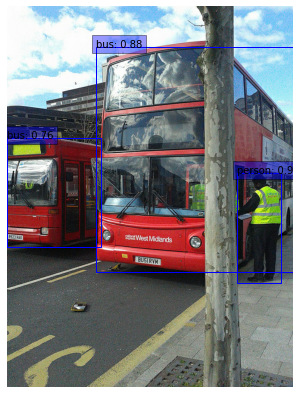

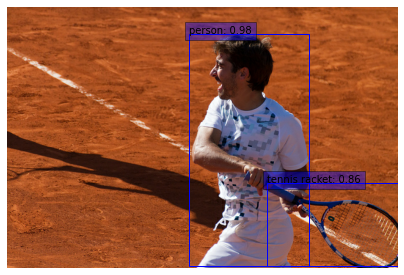

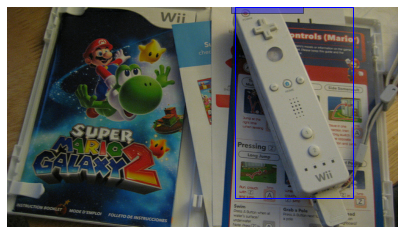

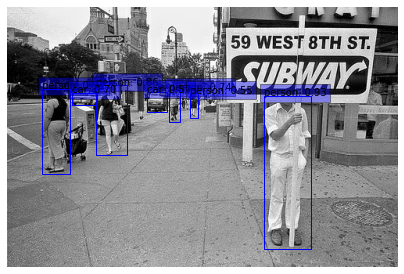

In [44]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio


val_dataset = tfds.load("coco/2017", split="validation", data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str

for sample in val_dataset.take(4):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )